# Manage a pathway registry

## Background

Pathways in single-cell analysis represent the interconnected networks of molecular signaling cascades that govern critical cellular processes. They are of utmost importance as they offer a comprehensive understanding of the intricate regulatory mechanisms underlying cellular behavior, providing insights into disease pathogenesis, therapeutic responses, and the identification of potential targets for precision medicine and intervention strategies.

Managing pathways across different datasets is crucial in a biotech company to gain a comprehensive understanding of complex biological processes and facilitate efficient research and development.

In this notebook we are registering the 2023 GO Biological process pathway ontology with Lamin. Afterwards, we are linking the pathways to genes and conducting a pathway enrichment analysis on an interferon-beta treated dataset. Finally, we will demonstrate how to fetch datasets with pathway queries using Lamin.

## Setup

```{warning}

Please ensure that you have created or loaded a LaminDB instance before running the remaining part of this notebook!
```

In [ ]:
# A lamindb instance containing bionty schema (skip if you already loaded your instance)
!lamin init --storage ./enrichr --schema bionty

In [1]:
import lamindb as ln
import lnschema_bionty as lb

lb.settings.species = "human"  # globally set species

import gseapy as gp
import scanpy as sc
import matplotlib.pyplot as plt

from lamin_usecases import datasets as ds

ln.settings.verbosity = 3  # show hints
lb.settings.species = "human"  # globally set species

✅ Loaded instance: sunnyosun/analysis-usecase (lamindb 0.49.1)
💬 Loaded 1 Species record that matched name: human
✅ Set species: Species(id=uHJU, name=human, taxon_id=9606, scientific_name=homo_sapiens, updated_at=2023-08-03 15:15:47, bionty_source_id=cVM6, created_by_id=kmvZDIX9)
💬 Loaded 1 Species record that matched name: human
✅ Set species: Species(id=uHJU, name=human, taxon_id=9606, scientific_name=homo_sapiens, updated_at=2023-08-03 15:15:47, bionty_source_id=cVM6, created_by_id=kmvZDIX9)


## Fetch `GO_Biological_Process_2023` pathways annotated with human genes using Enrichr

First we fetch the "GO_Biological_Process_2023" pathways for humans using [GSEApy](https://github.com/zqfang/GSEApy) which wraps [GSEA](https://www.gsea-msigdb.org/gsea/index.jsp) and [Enrichr](https://maayanlab.cloud/Enrichr/).

In [4]:
go_bp = gp.get_library(name="GO_Biological_Process_2023", organism="Human")
print(f"Number of pathways {len(go_bp)}")

Number of pathways 5406


In [5]:
go_bp["ATF6-mediated Unfolded Protein Response (GO:0036500)"]

['MBTPS1', 'MBTPS2', 'XBP1', 'ATF6B', 'DDIT3', 'CREBZF']

Parse out the ontology_id from keys, convert into the format of {ontology_id: (name, genes)}

In [6]:
def parse_ontology_id_from_keys(key):
    """Parse out the ontology id.

    "ATF6-mediated Unfolded Protein Response (GO:0036500)" -> ("GO:0036500", "ATF6-mediated Unfolded Protein Response")
    """
    id = key.split(" ")[-1].replace("(", "").replace(")", "")
    name = key.replace(f" ({id})", "")
    return (id, name)

In [7]:
go_bp_parsed = {}

for key, genes in go_bp.items():
    id, name = parse_ontology_id_from_keys(key)
    go_bp_parsed[id] = (name, genes)

In [8]:
go_bp_parsed["GO:0036500"]

('ATF6-mediated Unfolded Protein Response',
 ['MBTPS1', 'MBTPS2', 'XBP1', 'ATF6B', 'DDIT3', 'CREBZF'])

## Register pathway ontology in LaminDB

In [9]:
pathway_bionty = lb.Pathway.bionty()  # equals to bionty.Pathway()
pathway_bionty

Output()

Pathway
Species: all
Source: go, 2023-05-10
#terms: 47514

📖 Pathway.df(): ontology reference table
🔎 Pathway.lookup(): autocompletion of terms
🎯 Pathway.search(): free text search of terms
🧐 Pathway.inspect(): check if identifiers are mappable
👽 Pathway.map_synonyms(): map synonyms to standardized names
🪜 Pathway.diff(): difference between two versions
🔗 Pathway.ontology: Pronto.Ontology object

Next, we register all the pathways and genes in LaminDB to finally link pathways to genes.

### Register pathway terms

To register the pathways we make use of {func}`docs:lamindb.parse` to directly parse the annotated GO pathway ontology IDs into LaminDB.

In [10]:
pathway_records = lb.Pathway.from_values(go_bp_parsed.keys(), lb.Pathway.ontology_id)

💬 Loaded 5406 Pathway records from Bionty that matched ontology_id: GO:0044208, GO:0051084, GO:0006103, GO:0061158, GO:0070935, ...


In [11]:
lb.Pathway.from_bionty(ontology_id="GO:0015868")

💬 Loaded 1 Pathway record from Bionty that matched ontology_id: GO:0015868


Pathway(id=SMqshx3Y, name=purine ribonucleotide transport, ontology_id=GO:0015868, description=The Directed Movement Of A Purine Ribonucleotide, Any Compound Consisting Of A Purine Ribonucleoside (A Purine Organic Base Attached To A Ribose Sugar) Esterified With (Ortho)Phosphate, Into, Out Of Or Within A Cell., bionty_source_id=7EC1, created_by_id=kmvZDIX9)

In [12]:
ln.save(pathway_records, parents=False)  # not recursing through parents

### Register gene symbols

Similarly, we use {func}`docs:lamindb.parse` for all Pathway associated genes to register them with LaminDB.

In [13]:
all_genes = {g for genes in go_bp.values() for g in genes}

In [14]:
gene_records = lb.Gene.from_values(all_genes, lb.Gene.symbol)

💬 Using global setting species = human
💬 Loaded 88 Gene records that matched symbol: CIAPIN1, RAD52, DBNDD1, DHX33, LAS1L, ...
💬 Loaded 2 Gene records that matched synonyms: FHL1, C1ORF112
💬 Loaded 15963 Gene records from Bionty that matched symbol: A4GNT, AAK1, AARS1, AARS2, AASDHPPT, ...
💬 Loaded 353 Gene records from Bionty that matched synonyms: ACAT1, ACAT2, ADAM23, ADCY3, AGT, ...
🔶 Multiple matches found in Bionty for 921 records: ABCB11, ABCC1, ABCC6, ABCF1, ABHD16A, ...
🔶 Created 47 Gene records for symbols: ACTMAP, AFD1, AZF1, CCL4L1, DGS2, ...


In [15]:
gene_records[:3]

[Gene(id=C9CV0ArPNHIg, symbol=CIAPIN1, ensembl_gene_id=ENSG00000005194, ncbi_gene_ids=57019, biotype=protein_coding, description=cytokine induced apoptosis inhibitor 1 [Source:HGNC Symbol;Acc:HGNC:28050], synonyms=CIAE2, updated_at=2023-08-03 15:15:55, species_id=uHJU, bionty_source_id=eY18, created_by_id=kmvZDIX9),
 Gene(id=SB11wEBaJykD, symbol=RAD52, ensembl_gene_id=ENSG00000002016, ncbi_gene_ids=5893, biotype=protein_coding, description=RAD52 homolog, DNA repair protein [Source:HGNC Symbol;Acc:HGNC:9824], synonyms=, updated_at=2023-08-03 15:15:55, species_id=uHJU, bionty_source_id=eY18, created_by_id=kmvZDIX9),
 Gene(id=jvgs2qsCwx5H, symbol=CFH, ensembl_gene_id=ENSG00000000971, ncbi_gene_ids=3075, biotype=protein_coding, description=complement factor H [Source:HGNC Symbol;Acc:HGNC:4883], synonyms=HF|HF1|ARMD4|HF2|ARMS1|FHL1|HUS, updated_at=2023-08-03 15:15:55, species_id=uHJU, bionty_source_id=eY18, created_by_id=kmvZDIX9)]

In [16]:
ln.save(gene_records);

### Link pathway to genes

Now that we are tracking all pathways and genes records, we can link both of them to make the pathways even more queryable.

In [17]:
gene_records_ids = {record.symbol: record for record in gene_records}

In [18]:
for pathway_record in pathway_records:
    pathway_genes = go_bp_parsed.get(pathway_record.ontology_id)[1]
    pathway_genes_records = [gene_records_ids.get(gene) for gene in pathway_genes]
    pathway_record.genes.set(pathway_genes_records)

Now genes are linked to pathways:

In [19]:
pathway_record.genes.list("symbol")

['XIAP', 'CARD8', 'CARD18', 'CST7']

## A interferon-beta treated dataset

We will now conduct a pathway enrichment analysis on a small peripheral blood mononuclear cell dataset that is split into control and stimulated groups.
The stimulated group was treated with interferon beta.

The dataset was initially obtained using `From "SeuratData::ifnb"`.

Let's load the dataset and look at the cell type annotations.

In [2]:
adata = ds.anndata_seurat_ifnb()
adata

Output()

AnnData object with n_obs × n_vars = 13999 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'
    var: 'features'
    uns: 'log1p'

In [ ]:
adata.obs["seurat_annotations"].value_counts()

For simplicity, we subset to "B Activated" cells:

In [20]:
adata_ba = adata[adata.obs.seurat_annotations == "B Activated"].copy()
adata_ba

AnnData object with n_obs × n_vars = 388 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'
    var: 'features'
    uns: 'log1p'

### Pathway enrichment analysis using Enrichr

This analysis is based on: https://gseapy.readthedocs.io/en/master/singlecell_usecase.html

First, we compute differentially expressed genes using a Wilcoxon test between stimulated and control cells.

In [21]:
# compute differentially expressed genes
sc.tl.rank_genes_groups(
    adata_ba,
    groupby="stim",
    use_raw=False,
    method="wilcoxon",
    groups=["STIM"],
    reference="CTRL",
)

rank_genes_groups_df = sc.get.rank_genes_groups_df(adata_ba, "STIM")

In [22]:
rank_genes_groups_df.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,ISG15,16.881584,5.923428,6.147295e-64,6.536230e-60
1,ISG20,16.857113,4.167713,9.302256e-64,6.536230e-60
2,IFIT3,14.587233,31.232290,3.386569e-48,1.586382e-44
3,IFI6,14.128634,6.471180,2.530019e-45,8.888589e-42
4,MX1,13.442097,6.241539,3.425901e-41,9.628837e-38


Next, we filter out up/down-regulated differentially expressed gene sets:

In [23]:
degs_up = rank_genes_groups_df[
    (rank_genes_groups_df["logfoldchanges"] > 0)
    & (rank_genes_groups_df["pvals_adj"] < 0.05)
]
degs_dw = rank_genes_groups_df[
    (rank_genes_groups_df["logfoldchanges"] < 0)
    & (rank_genes_groups_df["pvals_adj"] < 0.05)
]

In [24]:
degs_up.shape, degs_dw.shape

((89, 5), (47, 5))

Run pathway enrichment analysis on DEGs and plot top 10 pathways:

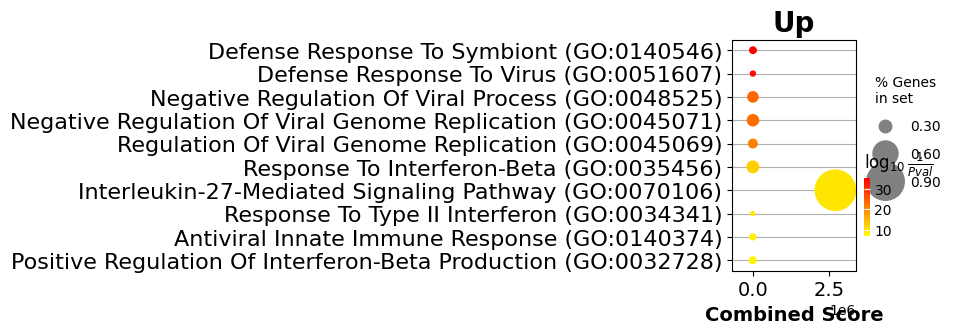

In [25]:
enr_up = gp.enrichr(degs_up.names, gene_sets="GO_Biological_Process_2023").res2d

gp.dotplot(enr_up, figsize=(2, 3), title="Up", cmap=plt.cm.autumn_r);

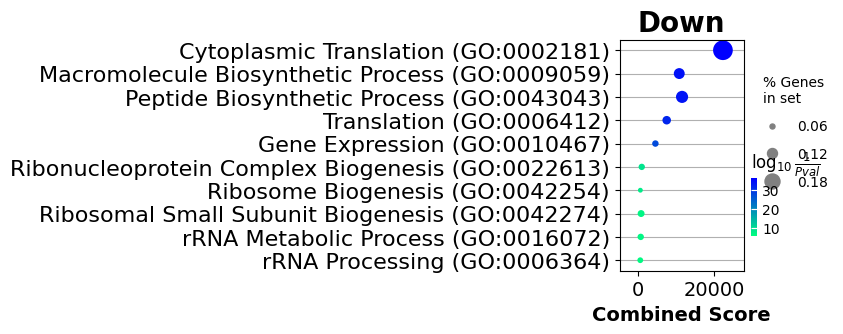

In [26]:
enr_dw = gp.enrichr(degs_dw.names, gene_sets="GO_Biological_Process_2023").res2d

gp.dotplot(enr_dw, figsize=(2, 3), title="Down", cmap=plt.cm.winter_r, size=10);

## Track datasets containing annotated pathways in LaminDB

Let's enable tracking of the current notebook as the transform of this file:

In [27]:
ln.track()

💬 Notebook imports: gseapy==1.0.4 lamin_usecases==0.0.1 lamindb==0.49.0 lnschema_bionty==0.28.2 matplotlib==3.7.1 scanpy==1.9.3
✅ Saved: Transform(id=6oxEIEduvo6wz8, name=Manage a pathway registry, short_name=enrichr, stem_id=6oxEIEduvo6w, version=0, type=notebook, updated_at=2023-08-03 15:34:35, created_by_id=kmvZDIX9)
✅ Saved: Run(id=yqUFZXVSWFtUCE8SGb3d, run_at=2023-08-03 15:34:35, transform_id=6oxEIEduvo6wz8, created_by_id=kmvZDIX9)


We further create a {func}`docs:lamindb.File` object to track the dataset.

In [29]:
file = ln.File.from_anndata(
    adata_ba, description="seurat_ifnb_activated_Bcells", var_ref=lb.Gene.symbol
)

💡 File will be copied to storage upon `save()` using storage key = qIRxw4Gxzub2zKjCMvCO.h5ad
💬 Parsing feature names of X, stored in slot .var
💬    Using global setting species = human
💬    Loaded 10173 Gene records that matched symbol: NOC2L, PLEKHN1, HES4, ISG15, AGRN, ...
💬    Loaded 921 Gene records that matched synonyms: CPSF3L, GLTPD1, C1orf86, SKI, FAM213B, ...
💬    Loaded 2655 Gene records from Bionty that matched symbol: A1BG, A1BG-AS1, A2M, A2M-AS1, A4GALT, ...
💬    Loaded 374 Gene records from Bionty that matched synonyms: AC002310.12, AC004854.4, AC007386.2, AC009133.12, AC016831.7, ...
🔶    Multiple matches found in Bionty for 151 records: AATF, ABR, ACAP1, ADCK5, ADI1, ...
🔶    Created 1305 Gene records for symbols: 7SK.2, AC000003.2, AC002117.1, AC002331.1, AC002451.3, ...
💬 Parsing feature names of slot .obs
🔶    Created 5 Feature records for names: orig.ident, nCount_RNA, nFeature_RNA, stim, seurat_annotations


In [30]:
ln.save(file)

💡 storing file qIRxw4Gxzub2zKjCMvCO with key .lamindb/qIRxw4Gxzub2zKjCMvCO.h5ad


We further create two {func}`docs:lamindb.Featureset` for `degs_up` and `degs_dw` which we can later associate with the associated pathways:

In [31]:
degs_up_featureset = ln.FeatureSet.from_values(degs_up.names, lb.Gene.symbol)

💬 Using global setting species = human
💬 Loaded 116 Gene records that matched symbol: ISG15, ISG20, IFIT3, IFI6, MX1, ...
💬 Loaded 8 Gene records that matched synonyms: SAT1, TAP1, WARS, SP110, NMI, ...


In [32]:
degs_dw_featureset = ln.FeatureSet.from_values(degs_dw.names, lb.Gene.symbol)

💬 Using global setting species = human
💬 Loaded 67 Gene records that matched symbol: RPS14, SH3BGRL3, PPIB, RPL11, EEF2, ...
💬 Loaded 4 Gene records that matched synonyms: GNB2L1, TMEM66, RPL13, RPL10


Link the top 10 pathways to the corresponding differentially expressed genes:

In [34]:
# get ontology ids for the top 10 pathways
enr_up_top10 = [
    pw_id[0] for pw_id in enr_up.head(10).Term.apply(parse_ontology_id_from_keys)
]
enr_dw_top10 = [
    pw_id[0] for pw_id in enr_dw.head(10).Term.apply(parse_ontology_id_from_keys)
]

# get pathway records
enr_up_top10_pathways = lb.Pathway.from_values(enr_up_top10, lb.Pathway.ontology_id)
enr_dw_top10_pathways = lb.Pathway.from_values(enr_dw_top10, lb.Pathway.ontology_id)

💬 Loaded 10 Pathway records that matched ontology_id: GO:0140546, GO:0051607, GO:0048525, GO:0045071, GO:0045069, ...
💬 Loaded 10 Pathway records that matched ontology_id: GO:0002181, GO:0009059, GO:0043043, GO:0006412, GO:0010467, ...


Associate the pathways to the differentially expressed genes:

In [35]:
degs_up_featureset.pathways.set(enr_up_top10_pathways)
degs_dw_featureset.pathways.set(enr_dw_top10_pathways)

In [36]:
degs_up_featureset.pathways.list("name")

['response to interferon-beta',
 'antiviral innate immune response',
 'positive regulation of interferon-beta production',
 'defense response to virus',
 'negative regulation of viral genome replication',
 'negative regulation of viral process',
 'interleukin-27-mediated signaling pathway',
 'regulation of viral genome replication',
 'defense response to symbiont',
 'response to type II interferon']

Link feature sets to file:

In [37]:
file.features.add_feature_set(degs_up_featureset, slot="up-DEGs")
file.features.add_feature_set(degs_dw_featureset, slot="down-DEGs")

IntegrityError: UNIQUE constraint failed: lnschema_core_filefeatureset.file_id, lnschema_core_filefeatureset.feature_set_id

## Querying for pathways

Querying for pathways is now simple with {func}`docs:lamindb.filter`:

In [38]:
lb.Pathway.filter(name__contains="interferon-beta").df()

,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,
GD9xCHBK,regulation of interferon-beta production,GO:0032648,None,regulation of IFN-beta production,"Any Process That Modulates The Frequency, Rate...",7EC1,2023-08-03 17:33:40,kmvZDIX9
uu9GYFx2,negative regulation of interferon-beta production,GO:0032688,None,down regulation of interferon-beta production|...,"Any Process That Stops, Prevents, Or Reduces T...",7EC1,2023-08-03 17:33:40,kmvZDIX9
l06ZujxW,cellular response to interferon-beta,GO:0035458,None,cellular response to fibroblast interferon|cel...,Any Process That Results In A Change In State ...,7EC1,2023-08-03 17:33:40,kmvZDIX9
mCgM7JYR,response to interferon-beta,GO:0035456,None,response to fiblaferon|response to fibroblast ...,Any Process That Results In A Change In State ...,7EC1,2023-08-03 17:33:40,kmvZDIX9
SGYMKD7O,positive regulation of interferon-beta production,GO:0032728,None,positive regulation of IFN-beta production|up-...,Any Process That Activates Or Increases The Fr...,7EC1,2023-08-03 17:33:40,kmvZDIX9


Query pathways from a gene:

In [39]:
lb.Pathway.filter(genes__symbol="KIR2DL1").df()

,name,ontology_id,abbr,synonyms,description,bionty_source_id,updated_at,created_by_id
id,,,,,,,,
TSXmNUbN,immune response-inhibiting cell surface recept...,GO:0002767,None,immune response-inhibiting cell surface recept...,The Series Of Molecular Signals Initiated By A...,7EC1,2023-08-03 17:33:40,kmvZDIX9


Query files from a pathway:

In [40]:
ln.File.filter(feature_sets__pathways__name__icontains="interferon-beta").first()

File(id=qIRxw4Gxzub2zKjCMvCO, suffix=.h5ad, accessor=AnnData, description=seurat_ifnb_activated_Bcells, size=5896640, hash=86NKRVPGDnZBzlpzBYd7gQ, hash_type=md5, updated_at=2023-08-03 15:34:58, storage_id=d862vu2G, transform_id=6oxEIEduvo6wz8, run_id=yqUFZXVSWFtUCE8SGb3d, created_by_id=kmvZDIX9)

Query featuresets from a pathway to learn from which geneset this pathway was computed:

In [41]:
pathway = lb.Pathway.filter(ontology_id="GO:0035456").one()
pathway

Pathway(id=mCgM7JYR, name=response to interferon-beta, ontology_id=GO:0035456, synonyms=response to fiblaferon|response to fibroblast interferon|response to interferon beta, description=Any Process That Results In A Change In State Or Activity Of A Cell Or An Organism (In Terms Of Movement, Secretion, Enzyme Production, Gene Expression, Etc.) As A Result Of An Interferon-Beta Stimulus. Interferon-Beta Is A Type I Interferon., updated_at=2023-08-03 15:33:40, bionty_source_id=7EC1, created_by_id=kmvZDIX9)

In [42]:
degs = ln.FeatureSet.filter(pathways__ontology_id=pathway.ontology_id).one()

Now we can get the list of genes that are differentially expressed and belong to this pathway:

In [43]:
pathway_genes = set(pathway.genes.list("symbol"))
degs_genes = set(degs.genes.list("symbol"))

In [44]:
pathway_genes.intersection(degs_genes)

{'BST2',
 'IFI16',
 'IFITM2',
 'IFITM3',
 'IRF1',
 'OAS1',
 'PLSCR1',
 'STAT1',
 'XAF1'}

## Conclusion

Registering pathways and associated gene sets is made simple with {func}`docs:lamindb.parse` that ensures that all parsed objects are linked to ontology IDs.Linking both sets is possible with {func}`docs:lamindb.Featureset` to facilitate simple querying for datasets that contain specific pathways. Since the pathways are linked to genes, Lamin also enables fetching the associated genes of a registered pathway to, for usecase, retrieve sets of differentially expressed genes that are a part of a specific pathway.

## Try it yourself

This notebook is available at [https://github.com/laminlabs/lamin-usecases](https://github.com/laminlabs/lamin-usecases).

In [ ]:
!lamin delete enrichr
!rm -r ./enrichr